# Consumer Fraud Imputation Model

This notebook focuses on creating a model to impute the missing average fraud probability for some consumers.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

In [ ]:
CLE = Path("../data/cleaned")
CUR = Path("../data/curated")
RAW_EXT = Path("../data/raw/external_dataset")

In [3]:
consumer_df = pd.read_csv(CUR / "full_consumer_df.csv")
print(f"Dataframe shape: {consumer_df.shape}")

Dataframe shape: (20111, 36)


In [4]:
# Check for columns with any missing values
null_counts = consumer_df.isnull().sum()
null_cols = null_counts[null_counts > 0]

print("Columns with missing values and their counts:")
print(null_cols.sort_values(ascending=False))

Columns with missing values and their counts:
fraud_prob_avg    3327
dtype: int64


We will impute the missing 3327 average fraud probability for consumers using the 16,784 other consumers.

In [ ]:
consumer_df["fraud_prob_avg"].mean()

0.15714298756118705

### Prep for Modelling

In [ ]:
# Split rows with/without target
target_col = "fraud_prob_avg"
has_y = consumer_df[target_col].notna()

train_df = consumer_df[has_y].copy()
pred_df  = consumer_df[~has_y].copy()

# Feature set
cat_cols = [c for c in ["state", "postcode", "gender", "SA2_code"] if c in consumer_df.columns]

num_cols = [c for c in [
    "transaction_count", "total_spend", "avg_spend", "unique_merchants",

    # GCP/SEIFA/WPP style features 
    "median_weekly_personal_income","household_personal_gap","dependency_ratio",
    "pct_youth","pct_seniors","unemployment_rate","full_time_share","part_time_share",
    "Incorporated","Unincorporated","Enterprises with no Employees",
    "Enterprises with not stated Employees","high_skill_occ","med_skill_occ","low_skill_occ",
    "irsd","irsad","ier","ieo","population","ATMs", "Bank_post", "Branch","Other face–to–face"
] if c in consumer_df.columns]

X = train_df[cat_cols + num_cols]
y = train_df[target_col].astype(float)

In [ ]:
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Model
Our baseline model is to impute missing consumer's fraud_prob_avg by taking the median of other consumers that live in the same SA2 area.

This was done because:
- Fraud probabilities are typically right-skewed with rare spikes -> median resists those outliers.
- The hierarchical fill (SA2 → state → global) preserves locality where possible but still guarantees coverage.

In [ ]:
def build_group_stats(df):
    sa2_stat = df.groupby("SA2_code")[target_col].median()
    state_stat = df.groupby("state")[target_col].median()
    global_stat = df[target_col].median()
    return sa2_stat, state_stat, global_stat

In [ ]:
def impute_hierarchical(df, sa2_stat, state_stat, global_stat):
    filled = df[target_col].copy()
    idx = filled.isna()
    if idx.any():
        filled.loc[idx] = df.loc[idx, "SA2_code"].map(sa2_stat)
    idx = filled.isna()
    if idx.any():
        filled.loc[idx] = df.loc[idx, "state"].map(state_stat)
    idx = filled.isna()
    if idx.any():
        filled.loc[idx] = global_stat
    return filled

In [ ]:
# Build stats on training subset
X_tr_local = X_tr.copy()
X_tr_local[target_col] = y_tr.values
sa2_stat, state_stat, global_stat = build_group_stats(X_tr_local)

# Apply imputation to validation set (pretend missing)
X_va_local = X_va.copy()
X_va_local[target_col] = np.nan
y_pred_val = impute_hierarchical(X_va_local, sa2_stat, state_stat, global_stat)

# Evaluate 
mae = mean_absolute_error(y_va, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_va, y_pred_val))

print(f"Median Imputation MAE:  {mae:.4f}")
print(f"Median Imputation RMSE: {rmse:.4f}")

Median Imputation MAE:  0.0568
Median Imputation RMSE: 0.1038


## Test different models on validation set

### Linear Regression

In [ ]:
# Apply log transform (small epsilon to avoid log(0))
eps = 1e-6
y_log = np.log(y + eps)

# Recompute y for training/validation with log-transform
Y_tr = np.log(y_tr + eps)
y_va_log = np.log(y_va + eps)

# Pipeline: Standardize numeric + OneHotEncode categoricals + LinearRegression
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

linreg = LinearRegression()
pipe = Pipeline([("pre", pre), ("linreg", linreg)])

# Fit model on training set 
pipe.fit(X_tr, Y_tr)

# Predict on validation set & convert to original scale
y_hat_log = pipe.predict(X_va)
y_hat = np.exp(y_hat_log) - eps 

# Evaluation metrics 
r2 = r2_score(y_va, y_hat)
mae = mean_absolute_error(y_va, y_hat)
rmse = np.sqrt(mean_squared_error(y_va, y_hat))

print(f"Validation R²:   {r2:.4f}")
print(f"Validation MAE:  {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

Validation R²:   -0.0854
Validation MAE:  0.0590
Validation RMSE: 0.1002


### Random Forest Regression

In [ ]:
# Create pipeline to one hot encode categorical columns
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="passthrough"  # Keep numeric columns as-is
)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([("pre", pre), ("rf", rf)])

In [ ]:
# Train/valid split for a quick check
pipe.fit(X_tr, y_tr)
y_hat = pipe.predict(X_va)

# Metrics
r2 = r2_score(y_va, y_hat)
mae = mean_absolute_error(y_va, y_hat)
mse = mean_squared_error(y_va, y_hat)
rmse = np.sqrt(mse)

print(f"Validation R²:  {r2:.3f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

Validation R²:  -0.042
Validation MAE: 0.0580
Validation RMSE: 0.0982


### KNN Imputer

In [ ]:
# Group by SA2_code and count number of consumers in each postcode
sa2_counts = consumer_df.groupby("SA2_code")["consumer_id"].nunique()

# Calculate the average number of consumers per SA2
avg_consumers_per_sa2 = sa2_counts.mean()

print(f"Average number of consumers per SA2: {avg_consumers_per_sa2:.2f}")
print(f"Total SA2 regions: {sa2_counts.shape[0]}")

Average number of consumers per SA2: 13.47
Total SA2 regions: 1493


In [ ]:
# Pipeline: Standardize + OneHotEncode + KNN 
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

knn = KNeighborsRegressor(n_neighbors=20, weights="distance", n_jobs=-1)

pipe_knn = Pipeline([("pre", pre), ("knn", knn)])

# Fit model on training set
pipe_knn.fit(X_tr, y_tr)

# Predict on validation set
y_hat = pipe_knn.predict(X_va)

# Evaluation metrics
r2 = r2_score(y_va, y_hat)
mae = mean_absolute_error(y_va, y_hat)
rmse = np.sqrt(mean_squared_error(y_va, y_hat))

print(f"Validation R²:   {r2:.4f}")
print(f"Validation MAE:  {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

Validation R²:   0.0429
Validation MAE:  0.0578
Validation RMSE: 0.0941


### Gradient Boosting

In [ ]:
# Pipeline: OneHotEncode + GBR 
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

gbr = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

pipe = Pipeline([("pre", pre), ("gbr", gbr)])

# Train/validation
pipe.fit(X_tr, y_tr)
y_hat = pipe.predict(X_va)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_va, y_hat))
mae  = mean_absolute_error(y_va, y_hat)
r2   = r2_score(y_va, y_hat)

print(f"Validation R²:   {r2:.4f}")
print(f"Validation MAE:  {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

Validation R²:   0.0619
Validation MAE:  0.0572
Validation RMSE: 0.0931


### XGBoost

In [ ]:
# Pipeline: OneHotEncode + XGB 
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

# XGBoost model 
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist", 
    eval_metric="rmse"
)

pipe_xgb = Pipeline([("pre", pre), ("xgb", xgb)])

pipe_xgb.fit(X_tr, y_tr)
y_hat = pipe_xgb.predict(X_va)

rmse =  np.sqrt(mean_squared_error(y_va, y_hat))
mae  = mean_absolute_error(y_va, y_hat)
r2   = r2_score(y_va, y_hat)

print(f"XGBoost – R2: {r2:.3f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

XGBoost – R2: 0.064 | RMSE: 0.0930 | MAE: 0.0570


## Final Imputation (KNN)

In [ ]:
# Refit on all labeled data (train + val) before imputing
pipe_full = clone(pipe_knn)        # keeps the same preprocessing + model settings
pipe_full.fit(X, y)

# Predict for rows missing the target
X_missing = pred_df[cat_cols + num_cols]
pred_df["consumer_fraud_prob_avg_imputed"] = pipe_full.predict(X_missing)

# Keep original values where present; use predictions where missing
train_df["consumer_fraud_prob_avg_imputed"] = train_df[target_col].values

cons_imputed = pd.concat(
    [
        train_df[["consumer_id", "consumer_fraud_prob_avg_imputed"]],
        pred_df[["consumer_id", "consumer_fraud_prob_avg_imputed"]],
    ],
    ignore_index=True,
)

In [ ]:
# Merge back to the consumer table and build the final filled column
consumer_sa2_imputed = consumer_df.merge(cons_imputed, on="consumer_id", how="left")
consumer_sa2_imputed["consumer_fraud_prob_avg_filled"] = consumer_sa2_imputed[
    target_col
].where(
    consumer_sa2_imputed[target_col].notna(),
    consumer_sa2_imputed["consumer_fraud_prob_avg_imputed"],
)

In [ ]:
consumer_sa2_imputed.head(10)

,SA2_code,consumer_id,transaction_count,total_spend,unique_merchants,avg_spend,fraud_prob_avg,name,address,state,...,irsad,irsd,ier,ieo,ATMs,Bank_post,Branch,Other face-to-face,consumer_fraud_prob_avg_imputed,consumer_fraud_prob_avg_filled
0,209031212,1003027,587,86617.587391,354,147.559774,0.130015,David Mckee,879 Owens Fords,VIC,...,1076.0,1086.0,1111.0,1064.0,0.0,3.0,0.0,0.0,0.130015,0.130015
1,402041046,1008991,572,82703.007667,336,144.585678,0.128273,Vanessa Wilson,576 Janet Key Suite 205,SA,...,827.0,803.0,876.0,851.0,21.0,4.0,9.0,0.0,0.128273,0.128273
2,402021030,1011771,567,83051.927812,332,146.476063,NaN,Teresa Simmons,0461 Bruce Fords,SA,...,717.0,646.0,758.0,773.0,11.0,3.0,4.0,0.0,0.162404,0.162404
3,206041504,1027927,545,99927.180487,334,183.352625,0.237482,Cody Cox,25036 Peterson Greens,VIC,...,1051.0,961.0,716.0,1139.0,22.0,1.0,7.0,0.0,0.237482,0.237482
4,402021030,1045351,569,87889.371809,336,154.462868,0.182754,Nicole Macias,8761 Thomas Trail,SA,...,717.0,646.0,758.0,773.0,11.0,3.0,4.0,0.0,0.182754,0.182754
5,127031524,105079,576,85645.325668,351,148.689802,0.121745,Christian Hernandez,19373 Lindsay Glens Suite 917,NSW,...,1068.0,1064.0,1070.0,1046.0,2.0,1.0,2.0,0.0,0.121745,0.121745
6,206041504,1065883,589,89835.842234,352,152.522652,0.112894,Alan Stewart,54629 Clark Centers,VIC,...,1051.0,961.0,716.0,1139.0,22.0,1.0,7.0,0.0,0.112894,0.112894
7,212041460,1099742,584,74476.883226,339,127.528910,NaN,Benjamin Martin,54158 Price Brooks Apt. 760,VIC,...,888.0,853.0,914.0,919.0,6.0,1.0,1.0,0.0,0.140970,0.140970
8,212041460,1119173,568,89732.084814,346,157.979023,0.185248,Breanna Bennett,45054 Gregory Land,VIC,...,888.0,853.0,914.0,919.0,6.0,1.0,1.0,0.0,0.185248,0.185248
9,402041046,1126954,553,84427.610718,343,152.671990,NaN,Ernest Santos,2454 Bishop Ports Suite 530,SA,...,827.0,803.0,876.0,851.0,21.0,4.0,9.0,0.0,0.172147,0.172147


In [ ]:
# Select only the required columns you want
consumer_sa2_imputed[["consumer_id", "consumer_fraud_prob_avg_filled"]] \
    .to_parquet(CUR / "consumer_fraud_prob_imputed.parquet", index=False)

## Check feature importance

Calculate the permutation importance to see which features contribute most to the model’s predictive power by measuring the performance drop when each feature is shuffled.

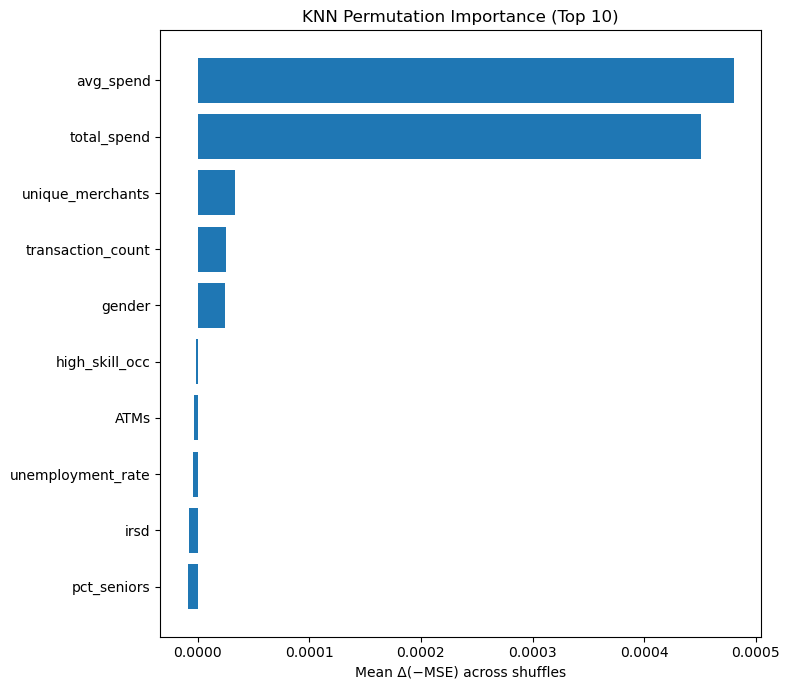

In [ ]:
# Get feature names
orig_feature_names = cat_cols + num_cols

# Compute permutation importance
result = permutation_importance(
    pipe_knn, X_va, y_va,
    scoring="neg_mean_squared_error",
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

perm_df = (
    pd.DataFrame({
        "feature": orig_feature_names,
        "importance": result.importances_mean,
        "std": result.importances_std
    })
    .sort_values("importance", ascending=False)
)

# Plot
top_n = 10
plt.figure(figsize=(8, 7))
plt.barh(perm_df.head(top_n)["feature"], perm_df.head(top_n)["importance"])
plt.gca().invert_yaxis()
plt.title(f"KNN Permutation Importance (Top {top_n})")
plt.xlabel("Mean Δ(−MSE) across shuffles")
plt.tight_layout()
plt.show()

This permutation importance plot shows that consumer-level spending behavior is by far the most predictive signal for imputing `fraud_prob_avg`. Both `avg_spend` and `total_spend` dominate the feature ranking, indicating that consumers who spend more or have higher per-transaction averages have systematically different fraud probabilities. 

Demographic and regional features such as `gender`, `Branch` (banking presence), and `Incorporated` contribute modestly, suggesting that where consumers live and their regional economic context add some additional signal. This result reinforces that transactional behavior is the strongest determinant, and external datasets mainly serve as weak enrichment rather than primary predictors.